# Agent Memory: Building Memory-Enabled Agents with LangGraph

In this notebook, we'll explore **agent memory systems** - the ability for AI agents to remember information across interactions. We'll implement all five memory types from the **CoALA (Cognitive Architectures for Language Agents)** framework while building on our Personal Wellness Assistant use case.

**Learning Objectives:**
- Understand the 5 memory types from the CoALA framework
- Implement short-term memory with checkpointers and thread_id
- Build long-term memory with InMemoryStore and namespaces
- Use semantic memory for meaning-based retrieval
- Apply episodic memory for few-shot learning from past experiences
- Create procedural memory for self-improving agents
- Combine all memory types into a unified wellness agent

## Table of Contents:

- **Breakout Room #1:** Memory Foundations
  - Task 1: Dependencies
  - Task 2: Understanding Agent Memory (CoALA Framework)
  - Task 3: Short-Term Memory (MemorySaver, thread_id)
  - Task 4: Long-Term Memory (InMemoryStore, namespaces)
  - Task 5: Message Trimming & Context Management
  - Question #1 & Question #2
  - 🏗️ Activity #1: Store & Retrieve User Wellness Profile

- **Breakout Room #2:** Advanced Memory & Integration
  - Task 6: Semantic Memory (Embeddings + Search)
  - Task 7: Building Semantic Wellness Knowledge Base
  - Task 8: Episodic Memory (Few-Shot Learning)
  - Task 9: Procedural Memory (Self-Improving Agent)
  - Task 10: Unified Wellness Memory Agent
  - Question #3 & Question #4
  - 🏗️ Activity #2: Wellness Memory Dashboard

---
# 🤝 Breakout Room #1
## Memory Foundations

## Task 1: Dependencies

Before we begin, make sure you have:

1. **API Keys** for:
   - OpenAI (for GPT-4o-mini and embeddings)
   - LangSmith (optional, for tracing)

2. **Dependencies installed** via `uv sync`

In [1]:
# Core imports
import os
import getpass
from uuid import uuid4
from typing import Annotated, TypedDict

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

In [2]:
# Set API Keys
# os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
# Optional: LangSmith for tracing
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = f"AIE9 - Agent Memory - {uuid4().hex[0:8]}"
# os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key (press Enter to skip): ") or ""

# if not os.environ["LANGCHAIN_API_KEY"]:
#     os.environ["LANGCHAIN_TRACING_V2"] = "false"
#     print("LangSmith tracing disabled")
# else:
#     print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")

LangSmith tracing enabled. Project: AIE9 - Agent Memory - 4c3e77a2


In [4]:
# Initialize LLM
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Test the connection
response = llm.invoke("Say 'Memory systems ready!' in exactly those words.")
print(response.content)

Memory systems ready!


## Task 2: Understanding Agent Memory (CoALA Framework)

The **CoALA (Cognitive Architectures for Language Agents)** framework identifies 5 types of memory that agents can use:

| Memory Type | Human Analogy | AI Implementation | Wellness Example |
|-------------|---------------|-------------------|------------------|
| **Short-term** | What someone just said | Conversation history within a thread | Current consultation conversation |
| **Long-term** | Remembering a friend's birthday | User preferences stored across sessions | User's goals, allergies, conditions |
| **Semantic** | Knowing Paris is in France | Facts retrieved by meaning | Wellness knowledge retrieval |
| **Episodic** | Remembering your first day at work | Learning from past experiences | Past successful advice patterns |
| **Procedural** | Knowing how to ride a bike | Self-improving instructions | Learned communication preferences |

### Memory Architecture Overview

```
┌─────────────────────────────────────────────────────────────────┐
│                    LangGraph Wellness Agent                     │
├─────────────────────────────────────────────────────────────────┤
│                                                                 │
│  ┌──────────────┐  ┌──────────────┐  ┌──────────────┐           │
│  │  Short-term  │  │  Long-term   │  │   Semantic   │           │
│  │    Memory    │  │    Memory    │  │    Memory    │           │
│  │              │  │              │  │              │           │
│  │ Checkpointer │  │    Store     │  │Store+Embed   │           │
│  │ + thread_id  │  │ + namespace  │  │  + search()  │           │
│  └──────────────┘  └──────────────┘  └──────────────┘           │
│                                                                 │
│  ┌──────────────┐  ┌──────────────┐                             │
│  │   Episodic   │  │  Procedural  │                             │
│  │    Memory    │  │    Memory    │                             │
│  │              │  │              │                             │
│  │  Few-shot    │  │Self-modifying│                             │
│  │  examples    │  │   prompts    │                             │
│  └──────────────┘  └──────────────┘                             │
│                                                                 │
└─────────────────────────────────────────────────────────────────┘
```

### Key LangGraph Components

| Component | Memory Type | Scope |
|-----------|-------------|-------|
| `MemorySaver` (Checkpointer) | Short-term | Within a single thread |
| `InMemoryStore` | Long-term, Semantic, Episodic, Procedural | Across all threads |
| `thread_id` | Short-term | Identifies unique conversations |
| Namespaces | All store-based | Organizes memories by user/purpose |

**Documentation:**
- [CoALA Paper](https://arxiv.org/abs/2309.02427)
- [LangGraph Memory Concepts](https://langchain-ai.github.io/langgraph/concepts/memory/)

## Task 3: Short-Term Memory (MemorySaver, thread_id)

**Short-term memory** maintains context within a single conversation thread. Think of it like your working memory during a phone call - you remember what was said earlier, but once the call ends, those details fade.

In LangGraph, short-term memory is implemented through:
- **Checkpointer**: Saves the graph state at each step
- **thread_id**: Uniquely identifies each conversation

### How It Works

```
Thread 1: "Hi, I'm Alice"          Thread 2: "What's my name?"
     │                                   │
     ▼                                   ▼
┌──────────────┐                   ┌──────────────┐
│ Checkpointer │                   │ Checkpointer │
│  thread_1    │                   │  thread_2    │
│              │                   │              │
│ ["Hi Alice"] │                   │ [empty]      │
└──────────────┘                   └──────────────┘
     │                                   │
     ▼                                   ▼
"Hi Alice!"                        "I don't know your name"
```

In [5]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

# Define the state schema for our graph
# The `add_messages` annotation tells LangGraph how to update the messages list
class State(TypedDict):
    messages: Annotated[list, add_messages]


# Define our wellness chatbot node
def wellness_chatbot(state: State):
    """Process the conversation and generate a wellness-focused response."""
    system_prompt = SystemMessage(content="""You are a friendly Personal Wellness Assistant. 
Help users with exercise, nutrition, sleep, and stress management questions.
Be supportive and remember details the user shares about themselves.""")
    
    messages = [system_prompt] + state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


# Build the graph
builder = StateGraph(State)
builder.add_node("chatbot", wellness_chatbot)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

# Compile with a checkpointer for short-term memory
checkpointer = MemorySaver()
wellness_graph = builder.compile(checkpointer=checkpointer)

print("Wellness chatbot compiled with short-term memory (checkpointing)")

Wellness chatbot compiled with short-term memory (checkpointing)


In [6]:
# Test short-term memory within a thread
config = {"configurable": {"thread_id": "wellness_thread_1"}}

# First message - introduce ourselves
response = wellness_graph.invoke(
    {"messages": [HumanMessage(content="Hi! My name is Sarah and I want to improve my sleep.")]},
    config
)
print("User: Hi! My name is Sarah and I want to improve my sleep.")
print(f"Assistant: {response['messages'][-1].content}")
print()

User: Hi! My name is Sarah and I want to improve my sleep.
Assistant: Hi Sarah! It's great to meet you! Improving sleep is such an important goal for overall wellness. Can you share a bit about your current sleep routine or any specific challenges you're facing with sleep? This will help me provide you with tailored advice!



In [7]:
# Second message - test if it remembers (same thread)
response = wellness_graph.invoke(
    {"messages": [HumanMessage(content="What's my name and what am I trying to improve?")]},
    config  # Same config = same thread_id
)
print("User: What's my name and what am I trying to improve?")
print(f"Assistant: {response['messages'][-1].content}")

User: What's my name and what am I trying to improve?
Assistant: Your name is Sarah, and you're looking to improve your sleep. How can I assist you further with that?


In [8]:
# New thread - it won't remember Sarah!
different_config = {"configurable": {"thread_id": "wellness_thread_2"}}

response = wellness_graph.invoke(
    {"messages": [HumanMessage(content="What's my name?")]},
    different_config  # Different thread_id = no memory of Sarah
)
print("User (NEW thread): What's my name?")
print(f"Assistant: {response['messages'][-1].content}")
print()
print("Notice: The agent doesn't know our name because this is a new thread!")

User (NEW thread): What's my name?
Assistant: I don't have your name yet! If you'd like to share it, I can remember it for our future conversations. How can I assist you today?

Notice: The agent doesn't know our name because this is a new thread!


In [9]:
# Inspect the state of thread 1
state = wellness_graph.get_state(config)
print(f"Thread 1 has {len(state.values['messages'])} messages:")
for msg in state.values['messages']:
    role = "User" if isinstance(msg, HumanMessage) else "Assistant"
    content = msg.content[:80] + "..." if len(msg.content) > 80 else msg.content
    print(f"  {role}: {content}")

Thread 1 has 4 messages:
  User: Hi! My name is Sarah and I want to improve my sleep.
  Assistant: Hi Sarah! It's great to meet you! Improving sleep is such an important goal for ...
  User: What's my name and what am I trying to improve?
  Assistant: Your name is Sarah, and you're looking to improve your sleep. How can I assist y...


## Task 4: Long-Term Memory (InMemoryStore, namespaces)

**Long-term memory** stores information across different conversation threads. This is like remembering that your friend prefers tea over coffee - you remember it every time you meet them, regardless of what you're currently discussing.

In LangGraph, long-term memory uses:
- **Store**: A persistent key-value store
- **Namespaces**: Organize memories by user, application, or context

### Key Difference from Short-Term Memory

| Short-Term (Checkpointer) | Long-Term (Store) |
|---------------------------|-------------------|
| Scoped to a single thread | Shared across all threads |
| Automatic (messages) | Explicit (you decide what to store) |
| Conversation history | User preferences, facts, etc. |

In [10]:
from langgraph.store.memory import InMemoryStore

# Create a store for long-term memory
store = InMemoryStore()

# Namespaces organize memories - typically by user_id and category
user_id = "user_sarah"
profile_namespace = (user_id, "profile")
preferences_namespace = (user_id, "preferences")

# Store Sarah's wellness profile
store.put(profile_namespace, "name", {"value": "Sarah"})
store.put(profile_namespace, "goals", {"primary": "improve sleep", "secondary": "reduce stress"})
store.put(profile_namespace, "conditions", {"allergies": ["peanuts"], "injuries": ["bad knee"]})

# Store Sarah's preferences
store.put(preferences_namespace, "communication", {"style": "friendly", "detail_level": "moderate"})
store.put(preferences_namespace, "schedule", {"preferred_workout_time": "morning", "available_days": ["Mon", "Wed", "Fri"]})

print("Stored Sarah's profile and preferences in long-term memory")

Stored Sarah's profile and preferences in long-term memory


In [11]:
# Retrieve specific memories
name = store.get(profile_namespace, "name")
print(f"Name: {name.value}")

goals = store.get(profile_namespace, "goals")
print(f"Goals: {goals.value}")

# List all memories in a namespace
print("\nAll profile items:")
for item in store.search(profile_namespace):
    print(f"  {item.key}: {item.value}")

Name: {'value': 'Sarah'}
Goals: {'primary': 'improve sleep', 'secondary': 'reduce stress'}

All profile items:
  name: {'value': 'Sarah'}
  goals: {'primary': 'improve sleep', 'secondary': 'reduce stress'}
  conditions: {'allergies': ['peanuts'], 'injuries': ['bad knee']}


In [12]:
from langgraph.store.base import BaseStore
from langchain_core.runnables import RunnableConfig

# Define state with user_id for personalization
class PersonalizedState(TypedDict):
    messages: Annotated[list, add_messages]
    user_id: str


def personalized_wellness_chatbot(state: PersonalizedState, config: RunnableConfig, *, store: BaseStore):
    """A wellness chatbot that uses long-term memory for personalization."""
    user_id = state["user_id"]
    profile_namespace = (user_id, "profile")
    preferences_namespace = (user_id, "preferences")
    
    # Retrieve user profile from long-term memory
    profile_items = list(store.search(profile_namespace))
    pref_items = list(store.search(preferences_namespace))
    
    # Build context from profile
    profile_text = "\n".join([f"- {p.key}: {p.value}" for p in profile_items])
    pref_text = "\n".join([f"- {p.key}: {p.value}" for p in pref_items])
    
    system_msg = f"""You are a Personal Wellness Assistant. You know the following about this user:

PROFILE:
{profile_text if profile_text else 'No profile stored.'}

PREFERENCES:
{pref_text if pref_text else 'No preferences stored.'}

Use this information to personalize your responses. Be supportive and helpful."""
    
    messages = [SystemMessage(content=system_msg)] + state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


# Build the personalized graph
builder2 = StateGraph(PersonalizedState)
builder2.add_node("chatbot", personalized_wellness_chatbot)
builder2.add_edge(START, "chatbot")
builder2.add_edge("chatbot", END)

# Compile with BOTH checkpointer (short-term) AND store (long-term)
personalized_graph = builder2.compile(
    checkpointer=MemorySaver(),
    store=store
)

print("Personalized graph compiled with both short-term and long-term memory")

Personalized graph compiled with both short-term and long-term memory


In [13]:
# Test the personalized chatbot - it knows Sarah's profile!
config = {"configurable": {"thread_id": "personalized_thread_1"}}

response = personalized_graph.invoke(
    {
        "messages": [HumanMessage(content="What exercises would you recommend for me?")],
        "user_id": "user_sarah"
    },
    config
)

print("User: What exercises would you recommend for me?")
print(f"Assistant: {response['messages'][-1].content}")
print()
print("Notice: The agent knows about Sarah's bad knee without her mentioning it!")

User: What exercises would you recommend for me?
Assistant: Hi Sarah! It's great that you're looking to improve your sleep and reduce stress through exercise. Given your bad knee, we want to focus on low-impact activities that are gentle on your joints. Here are some exercises you might enjoy, especially in the morning:

1. **Walking**: A brisk walk is a fantastic way to start your day. It’s low-impact and can help clear your mind.

2. **Swimming**: If you have access to a pool, swimming is excellent for a full-body workout without stressing your knee.

3. **Cycling**: Riding a stationary bike or cycling outdoors can be a great way to get your heart rate up while being easy on your knees.

4. **Yoga**: Gentle yoga can help with flexibility, relaxation, and stress reduction. Look for classes that focus on restorative or yin yoga.

5. **Pilates**: This can strengthen your core and improve your overall body awareness without putting too much strain on your knee.

6. **Strength Training**:

In [15]:
# Even in a NEW thread, it still knows Sarah's profile
# because long-term memory is cross-thread!

new_config = {"configurable": {"thread_id": "personalized_thread_2"}}

response = personalized_graph.invoke(
    {
        "messages": [HumanMessage(content="Can you suggest a snack for me?")],
        "user_id": "user_sarah"
    },
    new_config
)

print("User (NEW thread): Can you suggest a snack for me?")
print(f"Assistant: {response['messages'][-1].content}")
print()
print("Notice: Even in a new thread, the agent knows Sarah has a peanut allergy!")

User (NEW thread): Can you suggest a snack for me?
Assistant: Of course, Sarah! Here are a couple of snack ideas that are both delicious and safe for you:

1. **Rice Cakes with Hummus**: Rice cakes are light and crunchy, and you can spread some hummus on top for a tasty and satisfying snack. You can also add cucumber slices for extra crunch!

2. **Veggie Sticks with Guacamole**: Cut up some carrots, celery, and bell peppers, and dip them in guacamole. It’s a refreshing and nutritious option.

3. **Cottage Cheese with Pineapple**: This combination is not only tasty but also provides a good source of protein and vitamins.

4. **Trail Mix (without peanuts)**: You can make your own trail mix with nuts (like almonds or cashews), seeds, and dried fruit. Just be sure to avoid any mixes that contain peanuts.

Let me know if you’d like more ideas or if you have any specific preferences!

Notice: Even in a new thread, the agent knows Sarah has a peanut allergy!


## Task 5: Message Trimming & Context Management

Long conversations can exceed the LLM's context window. LangGraph provides utilities to manage message history:

- **`trim_messages`**: Keeps only recent messages up to a token limit
- **Summarization**: Compress older messages into summaries

### Why Trim Even with 128K Context?

Even with large context windows:
1. **Cost**: More tokens = higher API costs
2. **Latency**: Larger contexts take longer to process
3. **Quality**: Models can struggle with "lost in the middle" - important info buried in long contexts
4. **Relevance**: Old messages may not be relevant to current query

In [16]:
from langchain_core.messages import trim_messages

# Create a trimmer that keeps only recent messages
trimmer = trim_messages(
    max_tokens=500,  # Keep messages up to this token count
    strategy="last",  # Keep the most recent messages
    token_counter=llm,  # Use the LLM to count tokens
    include_system=True,  # Always keep system messages
    allow_partial=False,  # Don't cut messages in half
)

# Example: Create a long conversation
long_conversation = [
    SystemMessage(content="You are a wellness assistant."),
    HumanMessage(content="I want to improve my health."),
    AIMessage(content="Great goal! Let's start with exercise. What's your current activity level?"),
    HumanMessage(content="I walk about 30 minutes a day."),
    AIMessage(content="That's a good foundation. For cardiovascular health, aim for 150 minutes of moderate activity per week."),
    HumanMessage(content="What about nutrition?"),
    AIMessage(content="Focus on whole foods: vegetables, lean proteins, whole grains. Limit processed foods and added sugars."),
    HumanMessage(content="And sleep?"),
    AIMessage(content="Aim for 7-9 hours. Maintain a consistent sleep schedule and create a relaxing bedtime routine."),
    HumanMessage(content="What's the most important change I should make first?"),
]

# Trim to fit context window
trimmed = trimmer.invoke(long_conversation)
print(f"Original: {len(long_conversation)} messages")
print(f"Trimmed: {len(trimmed)} messages")
print("\nTrimmed conversation:")
for msg in trimmed:
    role = type(msg).__name__.replace("Message", "")
    content = msg.content[:60] + "..." if len(msg.content) > 60 else msg.content
    print(f"  {role}: {content}")

Original: 10 messages
Trimmed: 10 messages

Trimmed conversation:
  System: You are a wellness assistant.
  Human: I want to improve my health.
  AI: Great goal! Let's start with exercise. What's your current a...
  Human: I walk about 30 minutes a day.
  AI: That's a good foundation. For cardiovascular health, aim for...
  Human: What about nutrition?
  AI: Focus on whole foods: vegetables, lean proteins, whole grain...
  Human: And sleep?
  AI: Aim for 7-9 hours. Maintain a consistent sleep schedule and ...
  Human: What's the most important change I should make first?


In [17]:
# Summarization approach for longer conversations

def summarize_conversation(messages: list, max_messages: int = 6) -> list:
    """Summarize older messages to manage context length."""
    if len(messages) <= max_messages:
        return messages
    
    # Keep the system message and last few messages
    system_msg = messages[0] if isinstance(messages[0], SystemMessage) else None
    content_messages = messages[1:] if system_msg else messages
    
    if len(content_messages) <= max_messages:
        return messages
    
    old_messages = content_messages[:-max_messages+1]
    recent_messages = content_messages[-max_messages+1:]
    
    # Summarize old messages
    summary_prompt = f"""Summarize this conversation in 2-3 sentences, 
capturing key wellness topics discussed and any important user information:

{chr(10).join([f'{type(m).__name__}: {m.content[:200]}' for m in old_messages])}"""
    
    summary = llm.invoke(summary_prompt)
    
    # Return: system + summary + recent messages
    result = []
    if system_msg:
        result.append(system_msg)
    result.append(SystemMessage(content=f"[Previous conversation summary: {summary.content}]"))
    result.extend(recent_messages)
    
    return result


# Test summarization
summarized = summarize_conversation(long_conversation, max_messages=4)
print(f"Summarized: {len(summarized)} messages")
print("\nSummarized conversation:")
for msg in summarized:
    role = type(msg).__name__.replace("Message", "")
    content = msg.content[:80] + "..." if len(msg.content) > 80 else msg.content
    print(f"  {role}: {content}")

Summarized: 5 messages

Summarized conversation:
  System: You are a wellness assistant.
  System: [Previous conversation summary: The conversation centers around the user's desir...
  Human: And sleep?
  AI: Aim for 7-9 hours. Maintain a consistent sleep schedule and create a relaxing be...
  Human: What's the most important change I should make first?


---
## ❓ Question #1:

What are the trade-offs between **short-term memory** (checkpointer) vs **long-term memory** (store)? When should wellness data move from short-term to long-term?

Consider:
- What information should persist across sessions?
- What are the privacy implications of each?
- How would you decide what to promote from short-term to long-term?

##### Answer:
*Your answer here*

## ❓ Question #2:

Why use message trimming with a 128K context window when HealthWellnessGuide.txt is only ~16KB? What should **always** be preserved when trimming a wellness consultation?

Consider:
- The "lost in the middle" phenomenon
- Cost and latency implications
- What user information is critical for safety (allergies, conditions, etc.)

##### Answer:
Its meant to be a 2 way conversation, so user experience is impacted by response latency and larger context windows will impact that negatively.


---
## 🏗️ Activity #1: Store & Retrieve User Wellness Profile

Build a complete wellness profile system that:
1. Defines a wellness profile schema (name, goals, conditions, preferences)
2. Creates functions to store and retrieve profile data
3. Builds a personalized wellness agent that uses the profile
4. Tests that different users get different advice

### Requirements:
- Define at least 5 profile attributes
- Support multiple users with different profiles
- Agent should reference profile data in responses

In [ ]:
### YOUR CODE HERE ###

# Step 1: Define a wellness profile schema
# Example attributes: name, age, goals, conditions, allergies, fitness_level, preferred_activities

from typing import Literal
from pydantic import BaseModel, Field
from trustcall import create_extractor
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables.config import RunnableConfig

class MemoryState(MessagesState):
    user_id: str


# Create a store for long-term memory
store = InMemoryStore()

class ProfileSchema(BaseModel):
    name: Optional[str] = Field(description="name of user", frozen=True)
    age: Optional[str] = Field(description="age of user", frozen=True)
    gender: Optional[str] = Field(description="gender of user", frozen=True)
    occupation: Optional[str] = Field(description="job description indicates whether physical, or office work", frozen=True)
    conditions: Optional[List[str]] = Field(description="list of any medical conditions they may have")
    fitness_level: Optional[str] =  Field(description="self reported levels of general fitness")
    goals: Optional[List[str]] = Field(description="list of wellness related goals")
    sports: Optional[List[str]] =  Field(description="activites or sports user likes to do")
    available_times: Optional[List[str]] = Field(description="dates or times user is available")



# attributes heath_conditions, age, gender, occupation, fitness_level, medications


SYSTEM_PROMT = """
    You are a personalised wellness assistant that dispenses advice to users 
    to make helpful suggestions on how to improve their physical and mental heath.
"""

USER_PROMPT= """
    You have access to the following information about the user: 
    User profile - describes their demographics which do not change
    and should be considered immutable.
    Preferences - a list of current preferences but may change depending on their responses to your questions
        <user profile> 
        {user_profile}
        </user profile>


    Please make recommendations with reference to the user details provided above
"""
TRUSTCALL_PROMPT = """
    Create or update the memory (JSON doc) to incorporate information from the following conversation:
"""



In [475]:
# Step 2: Create helper functions to store and retrieve profiles

# Extraction instruction


def get_wellness_profile(store: BaseStore, user_id: str)-> ProfileSchema:
    """Retrieve a user's wellness profile.
    returns a  of user profiles"""

    user_profile =  store.get(('memory',user_id), 'user_profile')
    return user_profile

    

def store_wellness_profile(store: BaseStore, user_id: str, user_profile: ProfileSchema):
    store.put(('memory', user_id), 'user_profile', user_profile)




def update_profile_node(state: MemoryState, store: BaseStore,):
    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = state["user_id"]

    user_profile=get_wellness_profile(store, user_id).value

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_profile")
    print(f"existing_memory{existing_memory}")

    print(f"existing_memory.value.model_dump(): {existing_memory.value.model_dump()}")
    # Get the profile as the value from the list, and convert it to a JSON doc

    # Invoke the extractor
    patch = trustcall_extractor.invoke(
        {
            "messages": [SystemMessage(content=TRUSTCALL_PROMPT)]+state["messages"], 
            "existing":  {'ProfileSchema': existing_memory.value.model_dump()} 
        }
    )



    print(f"patch{patch}")
    # Get the updated profile as a JSON object
    updated_profile = existing_memory.value.model_copy(
        update= {key: value for key, value in patch['responses'][0].model_dump().items() if value}
    )

    # Save the updated profile
    key = "user_profile"
    store.put(namespace, key, updated_profile)

In [476]:
existing_profile{'ProfileSchema': ProfileSchema(name='dave', age='25', gender='male', occupation='fireman', conditions=['burns', 'lower back issues'], fitness_level='very fit', goals=['back pain relief', 'drink less'], sports=['boxing', 'weightlifting'], available_times=['varies depending on shift pattern'])}


SyntaxError: invalid syntax (1339418570.py, line 1)

In [477]:
# Update the conversation


# updated_conversation = [HumanMessage(content="Hi, I'm dave."), 
#                         AIMessage(content="Nice to meet you, dave."), 
#                         HumanMessage(content="I really like biking around San Francisco."),
#                         AIMessage(content="San Francisco is a great city! Where do you go after biking?"),
#                         HumanMessage(content="I really like to go to a bakery after biking."),]

# # Update the instruction
# system_msg = f"""Update the memory (JSON doc) to incorporate new information from the following conversation and any existing fields presented as an array or list of items should also be incorporated"""

# # Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
# patch = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+updated_conversation}, 
#                                     {"existing": {"ProfileSchema": user_profile_dave.model_dump()}})  

In [478]:
# Step 3: Create two different user profiles
user_profile_dave = ProfileSchema(
    name="dave", 
    age="25", 
    gender="male", 
    occupation="fireman",
    conditions = ["burns", "lower back issues"],
    fitness_level = "very fit",
    medications = ["sleeping pills"],
    goals= ["back pain relief", "drink less"],
    sports = ["boxing", "weightlifting"],
    available_times = ["varies depending on shift pattern"]
)
    

user_profile_fiona = ProfileSchema(
    name = "fiona", 
    age = "75", 
    gender = "female", 
    occupation = "retired",
    conditions = ["arthritis", "angina", "high cholesterol"],
    fitness_level = "very fit",
    medications = ["heart pills", "satins"] ,
    goals = ["keep active", "meet new people"],
    sports = ["walking", "dancing"],
    available_times = ["weekdays"]
)



In [479]:

# Step 4: Build a personalized agent that uses profiles



In [480]:
# graph = builder.compile(checkpointer=MemorySaver())
# config = {"configurable": {"thread_id": "1234"}}
# res = graph.invoke({"messages": [("user", "Hi there!")]}, config)
# res["messages"][-1].pretty_print()

In [481]:
# what we are doing is calling this after the agent loop is finished before we go to end.
#
# def write_memories(messages_history):
#     trustcall_extractor = create_extractor(
#     llm,
#     tools=[ProfileSchema],
#     tool_choice="ProfileSchema"
# )


#     # Update the instruction
#     system_msg = f"""Update the memory (JSON doc) to incorporate new information from the following conversation and any existing fields presented as an array or list of items should also be incorporated"""

#     # Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
#     patch = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+messages_history}, 
#                                     {"existing": {"ProfileSchema": user_profile_dave.model_dump()}})  


In [482]:
# remove empty fields to update the dict
# user_profile_dave2 = user_profile_dave.model_copy(update= 
# {key: value for key, value in patch['responses'][0].model_dump().items() if value})

# user_profile_dave2 = user_profile_dave.model_copy(update=patch['responses'][0].model_dump(exclude_unset=True))

In [483]:
def wellness_assistant_node(state: MemoryState, store: BaseStore):
    """personalised wellness assistant dispensing advice with reference to user profile and preferences"""

    """Get User_profile  from the store  to personalise  response."""
    
    # Get the user ID from the config
    user_id = state["user_id"]
    print(f"user_id:{user_id}")

    # Retrieve memory from the store
    user_profile = get_wellness_profile(store, user_id)
    print(user_profile)
    prompt = SYSTEM_PROMT + USER_PROMPT.format(
    user_profile=user_profile.value.model_dump_json(), 
    )

    # Respond using memory as well as the chat history
    response = llm.invoke([SystemMessage(content=prompt)]+state["messages"])

    return {"messages": response}

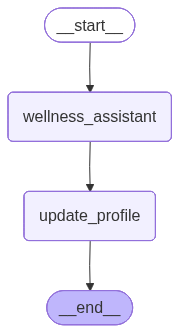

In [484]:
# Define the graph
state = MemoryState()
store = InMemoryStore()
# instatiate wellness profiles
store_wellness_profile(store, user_id="dave", user_profile=user_profile_dave)

# Checkpointer for short-term (within-thread) memory
st_memory = MemorySaver()
trustcall_extractor = create_extractor(
    llm,
    tools=[ProfileSchema],
    tool_choice="ProfileSchema"
)


builder = StateGraph(MemoryState)
builder.add_node("wellness_assistant", wellness_assistant_node)
builder.add_node("update_profile", update_profile_node)
builder.add_edge("wellness_assistant", "update_profile")
builder.add_edge(START, "wellness_assistant")
builder.add_edge("update_profile", END)





# Compile the graph with the checkpointer fir and store
assistant = builder.compile(checkpointer=st_memory, store=store)

# View
display(Image(assistant.get_graph(xray=1).draw_mermaid_png()))

In [487]:
# Step 5: Test with different users - they should get different advice

config = {"configurable": {"thread_id": "thread1"}}
updated_conversation = [HumanMessage(content="Hi, I'm dave."), 
                        AIMessage(content="Nice to meet you, dave."), 
                        HumanMessage(content="I really like biking."),
                        AIMessage(content="When do you do that?"),
                        HumanMessage(content="After my shifts. Usually in the evening"),]

assistant.invoke(
    {
        "messages": updated_conversation, 
        "user_id": "dave"
    }, config=config)



user_id:dave
Item(namespace=['memory', 'dave'], key='user_profile', value=ProfileSchema(name='dave', age='25', gender='male', occupation='fireman', conditions=['burns', 'lower back issues'], fitness_level='very fit', goals=['back pain relief', 'drink less'], sports=['boxing', 'weightlifting', 'biking'], available_times=['varies depending on shift pattern']), created_at='2026-01-31T19:06:32.067157+00:00', updated_at='2026-01-31T19:06:32.067158+00:00')
existing_memoryItem(namespace=['memory', 'dave'], key='user_profile', value=ProfileSchema(name='dave', age='25', gender='male', occupation='fireman', conditions=['burns', 'lower back issues'], fitness_level='very fit', goals=['back pain relief', 'drink less'], sports=['boxing', 'weightlifting', 'biking'], available_times=['varies depending on shift pattern']), created_at='2026-01-31T19:06:32.067157+00:00', updated_at='2026-01-31T19:06:32.067158+00:00')
existing_memory.value.model_dump(): {'name': 'dave', 'age': '25', 'gender': 'male', 'occ

{'messages': [HumanMessage(content="Hi, I'm dave.", additional_kwargs={}, response_metadata={}, id='6e8db0d3-9203-4691-b8d8-2c8c4041e6bf'),
  AIMessage(content='Nice to meet you, dave.', additional_kwargs={}, response_metadata={}, id='ac864090-9672-4c42-9b31-4178793a0a8a', tool_calls=[], invalid_tool_calls=[]),
  HumanMessage(content='I really like biking around San Francisco.', additional_kwargs={}, response_metadata={}, id='783ec2ab-1e19-4747-a40c-ee369b6f0b2f'),
  AIMessage(content='San Francisco is a great city! Where do you go after biking?', additional_kwargs={}, response_metadata={}, id='0bd8d439-2e3e-4367-b538-894bd2838d8d', tool_calls=[], invalid_tool_calls=[]),
  HumanMessage(content='I really like to go to a bakery after biking.', additional_kwargs={}, response_metadata={}, id='775e0658-0989-48f3-8f75-e0979f42c3fc'),
  AIMessage(content="That sounds like a nice way to reward yourself after a bike ride! Since you're looking to drink less and manage your back pain, you might w

In [488]:
get_wellness_profile(store, 'dave').value

ProfileSchema(name='dave', age='25', gender='male', occupation='fireman', conditions=['burns', 'lower back issues'], fitness_level='very fit', goals=['back pain relief', 'drink less'], sports=['boxing', 'weightlifting', 'biking'], available_times=['evenings after shifts'])

---
# 🤝 Breakout Room #2
## Advanced Memory & Integration

## Task 6: Semantic Memory (Embeddings + Search)

**Semantic memory** stores facts and retrieves them based on *meaning* rather than exact matches. This is like how you might remember "that restaurant with the great pasta" even if you can't remember its exact name.

In LangGraph, semantic memory uses:
- **Store with embeddings**: Converts text to vectors for similarity search
- **`store.search()`**: Finds relevant memories by semantic similarity

### How It Works

```
User asks: "What helps with headaches?"
         ↓
Query embedded → [0.2, 0.8, 0.1, ...]
         ↓
Compare with stored wellness facts:
  - "Hydration can relieve headaches" → 0.92 similarity ✓
  - "Exercise improves sleep" → 0.35 similarity
         ↓
Return: "Hydration can relieve headaches"
```

In [120]:
from langchain_openai import OpenAIEmbeddings

# Create embeddings model
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Create a store with semantic search enabled
semantic_store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 1536,  # Dimension of text-embedding-3-small
    }
)

print("Semantic memory store created with embedding support")

Semantic memory store created with embedding support


In [121]:
# Store various wellness facts as semantic memories
namespace = ("wellness", "facts")

wellness_facts = [
    ("fact_1", {"text": "Drinking water can help relieve headaches caused by dehydration"}),
    ("fact_2", {"text": "Regular exercise improves sleep quality and helps you fall asleep faster"}),
    ("fact_3", {"text": "Deep breathing exercises can reduce stress and anxiety within minutes"}),
    ("fact_4", {"text": "Eating protein at breakfast helps maintain steady energy levels throughout the day"}),
    ("fact_5", {"text": "Blue light from screens can disrupt your circadian rhythm and sleep"}),
    ("fact_6", {"text": "Walking for 30 minutes daily can improve cardiovascular health"}),
    ("fact_7", {"text": "Magnesium-rich foods like nuts and leafy greens can help with muscle cramps"}),
    ("fact_8", {"text": "A consistent sleep schedule, even on weekends, improves overall sleep quality"}),
]

for key, value in wellness_facts:
    semantic_store.put(namespace, key, value)

print(f"Stored {len(wellness_facts)} wellness facts in semantic memory")

Stored 8 wellness facts in semantic memory


In [122]:
# Search semantically - notice we don't need exact matches!

queries = [
    "My head hurts, what should I do?",
    "How can I get better rest at night?",
    "I'm feeling stressed and anxious",
    "What should I eat in the morning?",
]

for query in queries:
    print(f"\nQuery: {query}")
    results = semantic_store.search(namespace, query=query, limit=2)
    for r in results:
        print(f"   {r.value['text']} (score: {r.score:.3f})")


Query: My head hurts, what should I do?
   Drinking water can help relieve headaches caused by dehydration (score: 0.327)
   Magnesium-rich foods like nuts and leafy greens can help with muscle cramps (score: 0.173)

Query: How can I get better rest at night?
   Regular exercise improves sleep quality and helps you fall asleep faster (score: 0.463)
   A consistent sleep schedule, even on weekends, improves overall sleep quality (score: 0.426)

Query: I'm feeling stressed and anxious
   Deep breathing exercises can reduce stress and anxiety within minutes (score: 0.415)
   Drinking water can help relieve headaches caused by dehydration (score: 0.224)

Query: What should I eat in the morning?
   Eating protein at breakfast helps maintain steady energy levels throughout the day (score: 0.467)
   Walking for 30 minutes daily can improve cardiovascular health (score: 0.249)


## Task 7: Building Semantic Wellness Knowledge Base

Let's load the HealthWellnessGuide.txt and create a semantic knowledge base that our agent can search.

This is similar to RAG from Session 4, but now using LangGraph's Store API instead of a separate vector database.

In [123]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load and chunk the wellness document
loader = TextLoader("data/HealthWellnessGuide.txt")
documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100
)
chunks = text_splitter.split_documents(documents)

print(f"Loaded and split into {len(chunks)} chunks")
print(f"\nSample chunk:\n{chunks[0].page_content[:200]}...")

Loaded and split into 45 chunks

Sample chunk:
The Personal Wellness Guide
A Comprehensive Resource for Health and Well-being

PART 1: EXERCISE AND MOVEMENT

Chapter 1: Understanding Exercise Basics

Exercise is one of the most important things yo...


In [124]:
# Store chunks in semantic memory
knowledge_namespace = ("wellness", "knowledge")

for i, chunk in enumerate(chunks):
    semantic_store.put(
        knowledge_namespace,
        f"chunk_{i}",
        {"text": chunk.page_content, "source": "HealthWellnessGuide.txt"}
    )

print(f"Stored {len(chunks)} chunks in semantic knowledge base")

Stored 45 chunks in semantic knowledge base


In [125]:
# Build a semantic search wellness chatbot

class SemanticState(TypedDict):
    messages: Annotated[list, add_messages]
    user_id: str


def semantic_wellness_chatbot(state: SemanticState, config: RunnableConfig, *, store: BaseStore):
    """A wellness chatbot that retrieves relevant facts using semantic search."""
    user_message = state["messages"][-1].content
    
    # Search for relevant knowledge
    knowledge_results = store.search(
        ("wellness", "knowledge"),
        query=user_message,
        limit=3
    )
    
    # Build context from retrieved knowledge
    if knowledge_results:
        knowledge_text = "\n\n".join([f"- {r.value['text']}" for r in knowledge_results])
        system_msg = f"""You are a Personal Wellness Assistant with access to a wellness knowledge base.

Relevant information from your knowledge base:
{knowledge_text}

Use this information to answer the user's question. If the information doesn't directly answer their question, use your general knowledge but mention what you found."""
    else:
        system_msg = "You are a Personal Wellness Assistant. Answer wellness questions helpfully."
    
    messages = [SystemMessage(content=system_msg)] + state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


# Build and compile
builder3 = StateGraph(SemanticState)
builder3.add_node("chatbot", semantic_wellness_chatbot)
builder3.add_edge(START, "chatbot")
builder3.add_edge("chatbot", END)

semantic_graph = builder3.compile(
    checkpointer=MemorySaver(),
    store=semantic_store
)

print("Semantic wellness chatbot ready")

Semantic wellness chatbot ready


In [126]:
# Test semantic retrieval
config = {"configurable": {"thread_id": "semantic_thread_1"}}

questions = [
    "What exercises can help with lower back pain?",
    "How can I improve my sleep quality?",
    "What should I eat for better gut health?",
]

for q in questions:
    response = semantic_graph.invoke(
        {"messages": [HumanMessage(content=q)], "user_id": "test_user"},
        config
    )
    print(f"\nUser: {q}")
    print(f"Assistant: {response['messages'][-1].content[:500]}...")


User: What exercises can help with lower back pain?
Assistant: There are several effective exercises that can help alleviate lower back pain. Here are some recommended ones:

1. **Cat-Cow Stretch**: Start on your hands and knees. Alternate between arching your back up (like a cat) and letting it sag down (like a cow). Perform 10-15 repetitions.

2. **Bird Dog**: From a hands-and-knees position, extend your opposite arm and leg while keeping your core engaged. Hold for 5 seconds, then switch sides. Aim for 10 repetitions per side.

3. **Partial Crunches**: L...

User: How can I improve my sleep quality?
Assistant: Improving your sleep quality can be achieved through several essential sleep hygiene practices and creating an optimal sleep environment. Here are some tips:

### Sleep Hygiene Practices:
1. **Maintain a Consistent Sleep Schedule**: Go to bed and wake up at the same time every day, even on weekends.
2. **Create a Relaxing Bedtime Routine**: Engage in calming activities before

KeyboardInterrupt: 

## Task 8: Episodic Memory (Few-Shot Learning)

**Episodic memory** stores past experiences and uses them as examples for future tasks. In humans, this is like remembering the first time you successfully gave someone good advice and using that experience to guide future interactions.

For AI agents, episodic memory is often implemented as **few-shot examples** - showing the model examples of correct behavior so it can learn patterns.

### The CoALA Framework Perspective

> "Facts can be written to semantic memory, whereas **experiences** can be written to episodic memory."

Key insight: Sometimes it's easier to **show** than **tell**. LLMs learn well from examples!

In [ ]:
# Create episodic memory with past successful interactions
episodic_namespace = ("agent", "episodes")

successful_episodes = [
    {
        "situation": "User asked about starting exercise with joint pain",
        "input": "I want to start exercising but my knees hurt. What should I do?",
        "output": """For knee-friendly exercise, I'd recommend starting with low-impact activities:

1. **Swimming or water aerobics** - Water supports your joints while providing great cardio
2. **Cycling** - Either stationary or regular bikes are gentle on knees
3. **Elliptical machine** - Provides cardio without impact

Start slowly with 15-20 minutes and gradually increase. If you experience pain, stop and consult a healthcare provider. Would you like specific exercises for any of these?""",
        "feedback": "User appreciated the specific alternatives and safety advice"
    },
    {
        "situation": "User struggling with sleep and stress",
        "input": "I can't fall asleep because I'm always thinking about work. Help!",
        "output": """Racing thoughts at bedtime is common, especially with work stress. Here's a proven approach:

**Before bed:**
- Write down tomorrow's to-do list (gets thoughts out of your head)
- Set a "worry time" earlier in the evening - not at bedtime

**At bedtime:**
- Try the 4-7-8 breathing technique: Inhale 4 counts, hold 7, exhale 8
- Use the "cognitive shuffle" - think of random, unrelated objects (apple, guitar, mountain...)

Which of these would you like to try first?""",
        "feedback": "User found the structured approach and specific techniques helpful"
    },
    {
        "situation": "User asking about healthy eating on a budget",
        "input": "How can I eat healthy when I don't have much money?",
        "output": """Eating healthy on a budget is absolutely possible! Here are practical strategies:

**Budget-friendly nutritious foods:**
- Eggs, beans, lentils (cheap protein)
- Frozen vegetables (same nutrition as fresh, longer lasting)
- Oats, rice, whole grain bread
- Canned fish (tuna, salmon)

**Money-saving tips:**
- Buy in bulk when possible
- Plan meals around sales
- Cook in batches and freeze portions

What's your typical weekly food budget? I can help you create a specific meal plan.""",
        "feedback": "User valued the practical, actionable advice without judgment"
    },
]

for i, episode in enumerate(successful_episodes):
    semantic_store.put(
        episodic_namespace,
        f"episode_{i}",
        {
            "text": episode["situation"],  # Used for semantic search
            **episode
        }
    )

print(f"Stored {len(successful_episodes)} episodic memories (past successful interactions)")

Stored 3 episodic memories (past successful interactions)


In [ ]:
class EpisodicState(TypedDict):
    messages: Annotated[list, add_messages]


def episodic_wellness_chatbot(state: EpisodicState, config: RunnableConfig, *, store: BaseStore):
    """A chatbot that learns from past successful interactions."""
    user_question = state["messages"][-1].content
    
    # Search for similar past experiences
    similar_episodes = store.search(
        ("agent", "episodes"),
        query=user_question,
        limit=1
    )
    
    # Build few-shot examples from past episodes
    if similar_episodes:
        episode = similar_episodes[0].value
        few_shot_example = f"""Here's an example of a similar wellness question I handled well:

User asked: {episode['input']}

My response was:
{episode['output']}

The user feedback was: {episode['feedback']}

Use this as inspiration for the style, structure, and tone of your response, but tailor it to the current question."""
        
        system_msg = f"""You are a Personal Wellness Assistant. Learn from your past successes:

{few_shot_example}"""
    else:
        system_msg = "You are a Personal Wellness Assistant. Be helpful, specific, and supportive."
    
    messages = [SystemMessage(content=system_msg)] + state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


# Build the episodic memory graph
builder4 = StateGraph(EpisodicState)
builder4.add_node("chatbot", episodic_wellness_chatbot)
builder4.add_edge(START, "chatbot")
builder4.add_edge("chatbot", END)

episodic_graph = builder4.compile(
    checkpointer=MemorySaver(),
    store=semantic_store
)

print("Episodic memory chatbot ready")

Episodic memory chatbot ready


In [ ]:
# Test episodic memory - similar question to stored episode
config = {"configurable": {"thread_id": "episodic_thread_1"}}

response = episodic_graph.invoke(
    {"messages": [HumanMessage(content="I want to exercise more but I have a bad hip. What can I do?")]},
    config
)

print("User: I want to exercise more but I have a bad hip. What can I do?")
print(f"\nAssistant: {response['messages'][-1].content}")
print("\nNotice: The response structure mirrors the successful knee pain episode!")

User: I want to exercise more but I have a bad hip. What can I do?

Assistant: It's great that you want to exercise more! For a bad hip, focusing on low-impact activities can help you stay active while minimizing discomfort. Here are some options to consider:

1. **Swimming or water aerobics** - The buoyancy of water reduces stress on your hip joints while providing a full-body workout.
2. **Cycling** - Using a stationary bike or cycling outdoors can be gentle on your hips and still give you a good cardiovascular workout.
3. **Walking** - Start with short, flat walks and gradually increase your distance. Consider using supportive shoes and walking on softer surfaces like grass or tracks.
4. **Yoga or Pilates** - These practices can improve flexibility and strength without putting too much strain on your hips. Look for classes that focus on gentle movements.
5. **Resistance training** - Focus on upper body and core exercises that don’t involve your hips too much. You can use resistance 

## Task 9: Procedural Memory (Self-Improving Agent)

**Procedural memory** stores the rules and instructions that guide behavior. In humans, this is like knowing *how* to give good advice - it's internalized knowledge about performing tasks.

For AI agents, procedural memory often means **self-modifying prompts**. The agent can:
1. Store its current instructions in the memory store
2. Reflect on feedback from interactions
3. Update its own instructions to improve

### The Reflection Pattern

```
User feedback: "Your advice is too long and complicated"
         ↓
Agent reflects on current instructions
         ↓
Agent updates instructions: "Keep advice concise and actionable"
         ↓
Future responses use updated instructions
```

In [ ]:
# Initialize procedural memory with base instructions
procedural_namespace = ("agent", "instructions")

initial_instructions = """You are a Personal Wellness Assistant.

Guidelines:
- Be supportive and non-judgmental
- Provide evidence-based wellness information
- Ask clarifying questions when needed
- Encourage healthy habits without being preachy"""

semantic_store.put(
    procedural_namespace,
    "wellness_assistant",
    {"instructions": initial_instructions, "version": 1}
)

print("Initialized procedural memory with base instructions")
print(f"\nCurrent Instructions (v1):\n{initial_instructions}")

Initialized procedural memory with base instructions

Current Instructions (v1):
You are a Personal Wellness Assistant.

Guidelines:
- Be supportive and non-judgmental
- Provide evidence-based wellness information
- Ask clarifying questions when needed
- Encourage healthy habits without being preachy


In [ ]:
class ProceduralState(TypedDict):
    messages: Annotated[list, add_messages]
    feedback: str  # Optional feedback from user


def get_instructions(store: BaseStore) -> tuple[str, int]:
    """Retrieve current instructions from procedural memory."""
    item = store.get(("agent", "instructions"), "wellness_assistant")
    if item is None:
        return "You are a helpful wellness assistant.", 0
    return item.value["instructions"], item.value["version"]


def procedural_assistant_node(state: ProceduralState, config: RunnableConfig, *, store: BaseStore):
    """Respond using current procedural instructions."""
    instructions, version = get_instructions(store)
    
    messages = [SystemMessage(content=instructions)] + state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


def reflection_node(state: ProceduralState, config: RunnableConfig, *, store: BaseStore):
    """Reflect on feedback and update instructions if needed."""
    feedback = state.get("feedback", "")
    
    if not feedback:
        return {}  # No feedback, no update needed
    
    # Get current instructions
    current_instructions, version = get_instructions(store)
    
    # Ask the LLM to reflect and improve instructions
    reflection_prompt = f"""You are improving a wellness assistant's instructions based on user feedback.

Current Instructions:
{current_instructions}

User Feedback:
{feedback}

Based on this feedback, provide improved instructions. Keep the same general format but incorporate the feedback.
Only output the new instructions, nothing else."""
    
    response = llm.invoke([HumanMessage(content=reflection_prompt)])
    new_instructions = response.content
    
    # Update procedural memory with new instructions
    store.put(
        ("agent", "instructions"),
        "wellness_assistant",
        {"instructions": new_instructions, "version": version + 1}
    )
    
    print(f"\nInstructions updated to version {version + 1}")
    return {}


def should_reflect(state: ProceduralState) -> str:
    """Decide whether to reflect on feedback."""
    if state.get("feedback"):
        return "reflect"
    return "end"


# Build the procedural memory graph
builder5 = StateGraph(ProceduralState)
builder5.add_node("assistant", procedural_assistant_node)
builder5.add_node("reflect", reflection_node)

builder5.add_edge(START, "assistant")
builder5.add_conditional_edges("assistant", should_reflect, {"reflect": "reflect", "end": END})
builder5.add_edge("reflect", END)

procedural_graph = builder5.compile(
    checkpointer=MemorySaver(),
    store=semantic_store
)

print("Procedural memory graph ready (with self-improvement capability)")

Procedural memory graph ready (with self-improvement capability)


In [ ]:
# Test with initial instructions
config = {"configurable": {"thread_id": "procedural_thread_1"}}

response = procedural_graph.invoke(
    {
        "messages": [HumanMessage(content="How can I reduce stress?")],
        "feedback": ""  # No feedback yet
    },
    config
)

print("User: How can I reduce stress?")
print(f"\nAssistant (v1 instructions):\n{response['messages'][-1].content}")

User: How can I reduce stress?

Assistant (v1 instructions):
Reducing stress is a great goal, and there are several effective strategies you can try. Here are some evidence-based methods:

1. **Mindfulness and Meditation**: Practicing mindfulness or meditation can help you stay present and reduce anxiety. Even a few minutes a day can make a difference.

2. **Physical Activity**: Regular exercise is a powerful stress reliever. It can boost your mood and improve your overall health. Find an activity you enjoy, whether it's walking, dancing, or yoga.

3. **Deep Breathing**: Simple deep breathing exercises can help calm your mind and body. Try inhaling deeply through your nose, holding for a few seconds, and exhaling slowly through your mouth.

4. **Connect with Others**: Talking to friends or family can provide support and help you feel less isolated. Sometimes just sharing your feelings can lighten the load.

5. **Time Management**: Organizing your tasks and setting priorities can help y

In [ ]:
# Now provide feedback - the agent will update its own instructions!
response = procedural_graph.invoke(
    {
        "messages": [HumanMessage(content="How can I reduce stress?")],
        "feedback": "Your responses are too long. Please be more concise and give me 3 actionable tips maximum."
    },
    {"configurable": {"thread_id": "procedural_thread_2"}}
)


Instructions updated to version 2


In [ ]:
# Check the updated instructions
new_instructions, version = get_instructions(semantic_store)
print(f"Updated Instructions (v{version}):\n")
print(new_instructions)

Updated Instructions (v2):

You are a Personal Wellness Assistant.

Guidelines:
- Be supportive and non-judgmental
- Provide evidence-based wellness information
- Ask clarifying questions when needed
- Encourage healthy habits without being preachy
- Keep responses concise, offering a maximum of 3 actionable tips.


In [ ]:
# Test with updated instructions - should be more concise now!
response = procedural_graph.invoke(
    {
        "messages": [HumanMessage(content="How can I sleep better?")],
        "feedback": ""  # No feedback this time
    },
    {"configurable": {"thread_id": "procedural_thread_3"}}
)

print(f"User: How can I sleep better?")
print(f"\nAssistant (v{version} instructions - after feedback):")
print(response['messages'][-1].content)
print("\nNotice: The response should now be more concise based on the feedback!")

User: How can I sleep better?

Assistant (v2 instructions - after feedback):
Improving your sleep can have a significant impact on your overall wellness. Here are three actionable tips to help you sleep better:

1. **Establish a Consistent Sleep Schedule**: Try to go to bed and wake up at the same time every day, even on weekends. This helps regulate your body's internal clock.

2. **Create a Relaxing Bedtime Routine**: Engage in calming activities before bed, such as reading, gentle stretching, or meditation. Avoid screens for at least 30 minutes before sleep, as blue light can interfere with melatonin production.

3. **Optimize Your Sleep Environment**: Make your bedroom conducive to sleep by keeping it dark, cool, and quiet. Consider using blackout curtains, earplugs, or a white noise machine if needed.

Would you like more specific strategies or information on any of these tips?

Notice: The response should now be more concise based on the feedback!


## Task 10: Unified Wellness Memory Agent

Now let's combine **all 5 memory types** into a unified wellness agent:

1. **Short-term**: Remembers current conversation (checkpointer)
2. **Long-term**: Stores user profile across sessions (store + namespace)
3. **Semantic**: Retrieves relevant wellness knowledge (store + embeddings)
4. **Episodic**: Uses past successful interactions as examples (store + search)
5. **Procedural**: Adapts behavior based on feedback (store + reflection)

### Memory Retrieval Flow

```
User Query: "What exercises can help my back pain?"
              │
              ▼
┌─────────────────────────────────────────────────┐
│  1. PROCEDURAL: Get current instructions         │
│  2. LONG-TERM: Load user profile (conditions)    │
│  3. SEMANTIC: Search wellness knowledge          │
│  4. EPISODIC: Find similar past interactions     │
│  5. SHORT-TERM: Include conversation history     │
└─────────────────────────────────────────────────┘
              │
              ▼
        Generate personalized, informed response
```

In [ ]:
class UnifiedState(TypedDict):
    messages: Annotated[list, add_messages]
    user_id: str
    feedback: str


def unified_wellness_assistant(state: UnifiedState, config: RunnableConfig, *, store: BaseStore):
    """An assistant that uses all five memory types."""
    user_id = state["user_id"]
    user_message = state["messages"][-1].content
    
    # 1. PROCEDURAL: Get current instructions
    instructions_item = store.get(("agent", "instructions"), "wellness_assistant")
    base_instructions = instructions_item.value["instructions"] if instructions_item else "You are a helpful wellness assistant."
    
    # 2. LONG-TERM: Get user profile
    profile_items = list(store.search((user_id, "profile")))
    pref_items = list(store.search((user_id, "preferences")))
    profile_text = "\n".join([f"- {p.key}: {p.value}" for p in profile_items]) if profile_items else "No profile stored."
    
    # 3. SEMANTIC: Search for relevant knowledge
    relevant_knowledge = store.search(("wellness", "knowledge"), query=user_message, limit=2)
    knowledge_text = "\n".join([f"- {r.value['text'][:200]}..." for r in relevant_knowledge]) if relevant_knowledge else "No specific knowledge found."
    
    # 4. EPISODIC: Find similar past interactions
    similar_episodes = store.search(("agent", "episodes"), query=user_message, limit=1)
    if similar_episodes:
        ep = similar_episodes[0].value
        episode_text = f"Similar past interaction:\nUser: {ep.get('input', 'N/A')}\nResponse style: {ep.get('feedback', 'N/A')}"
    else:
        episode_text = "No similar past interactions found."
    
    # Build comprehensive system message
    system_message = f"""{base_instructions}

=== USER PROFILE ===
{profile_text}

=== RELEVANT WELLNESS KNOWLEDGE ===
{knowledge_text}

=== LEARNING FROM EXPERIENCE ===
{episode_text}

Use all of this context to provide the best possible personalized response."""
    
    # 5. SHORT-TERM: Full conversation history is automatically managed by the checkpointer
    # Use summarization for long conversations
    trimmed_messages = summarize_conversation(state["messages"], max_messages=6)
    
    messages = [SystemMessage(content=system_message)] + trimmed_messages
    response = llm.invoke(messages)
    return {"messages": [response]}


def unified_feedback_node(state: UnifiedState, config: RunnableConfig, *, store: BaseStore):
    """Update procedural memory based on feedback."""
    feedback = state.get("feedback", "")
    if not feedback:
        return {}
    
    item = store.get(("agent", "instructions"), "wellness_assistant")
    if item is None:
        return {}
    
    current = item.value
    reflection_prompt = f"""Update these instructions based on feedback:

Current: {current['instructions']}
Feedback: {feedback}

Output only the updated instructions."""
    
    response = llm.invoke([HumanMessage(content=reflection_prompt)])
    store.put(
        ("agent", "instructions"),
        "wellness_assistant",
        {"instructions": response.content, "version": current["version"] + 1}
    )
    print(f"Procedural memory updated to v{current['version'] + 1}")
    return {}


def unified_route(state: UnifiedState) -> str:
    return "feedback" if state.get("feedback") else "end"


# Build the unified graph
unified_builder = StateGraph(UnifiedState)
unified_builder.add_node("assistant", unified_wellness_assistant)
unified_builder.add_node("feedback", unified_feedback_node)

unified_builder.add_edge(START, "assistant")
unified_builder.add_conditional_edges("assistant", unified_route, {"feedback": "feedback", "end": END})
unified_builder.add_edge("feedback", END)

# Compile with both checkpointer (short-term) and store (all other memory types)
unified_graph = unified_builder.compile(
    checkpointer=MemorySaver(),
    store=semantic_store
)

print("Unified wellness assistant ready with all 5 memory types!")

Unified wellness assistant ready with all 5 memory types!


In [ ]:
# Test the unified assistant
config = {"configurable": {"thread_id": "unified_thread_1"}}

# First interaction - should use semantic + long-term + episodic memory
response = unified_graph.invoke(
    {
        "messages": [HumanMessage(content="What exercises would you recommend for my back?")],
        "user_id": "user_sarah",  # Sarah has a bad knee in her profile!
        "feedback": ""
    },
    config
)

print("User: What exercises would you recommend for my back?")
print(f"\nAssistant: {response['messages'][-1].content}")
print("\n" + "="*60)
print("Memory types used:")
print("  Long-term: Knows Sarah has a bad knee")
print("  Semantic: Retrieved back exercise info from knowledge base")
print("  Episodic: May use similar joint pain episode as reference")
print("  Procedural: Following current instructions")
print("  Short-term: Will remember this in follow-up questions")

User: What exercises would you recommend for my back?

Assistant: It's great that you're looking to support your back health! Here are three gentle exercises that can help relieve lower back pain:

1. **Cat-Cow Stretch**: Start on your hands and knees. Alternate between arching your back up (like a cat) and letting it sag down (like a cow). Aim for 10-15 repetitions to help increase flexibility and relieve tension.

2. **Bird-Dog**: From the same hands-and-knees position, extend one arm forward and the opposite leg back, keeping your back straight. Hold for a few seconds, then switch sides. This helps strengthen your core and lower back.

3. **Child’s Pose**: Kneel on the floor, sit back on your heels, and stretch your arms forward on the ground. This pose gently stretches the back and can provide relief.

Make sure to listen to your body and stop if you feel any pain. Have you tried any of these exercises before, or do you have any specific concerns about your back?

Memory types used

In [ ]:
# Follow-up question (tests short-term memory)
response = unified_graph.invoke(
    {
        "messages": [HumanMessage(content="Can you show me how to do the first one?")],
        "user_id": "user_sarah",
        "feedback": ""
    },
    config  # Same thread
)

print("User: Can you show me how to do the first one?")
print(f"\nAssistant: {response['messages'][-1].content}")
print("\nNotice: The agent remembers the context from the previous message!")

User: Can you show me how to do the first one?

Assistant: Absolutely! Here’s how to do the Cat-Cow Stretch step-by-step:

1. **Start Position**: Begin on your hands and knees on a comfortable surface, like a yoga mat. Your wrists should be directly under your shoulders, and your knees should be under your hips.

2. **Cat Pose**: Inhale deeply. As you exhale, round your back towards the ceiling, tucking your chin to your chest and drawing your belly button in towards your spine. This is the "cat" position.

3. **Cow Pose**: Inhale again. As you exhale, arch your back, letting your belly drop towards the floor while lifting your head and tailbone towards the ceiling. This is the "cow" position.

4. **Repeat**: Continue to alternate between these two positions for 10-15 repetitions, coordinating your breath with your movements.

Remember to move slowly and gently, focusing on your breath. How does that sound? Would you like tips on how to incorporate this into your routine?

Notice: The 

---
## ❓ Question #3:

How would you decide what constitutes a **"successful" wellness interaction** worth storing as an episode? What metadata should you store alongside the episode?

Consider:
- Explicit feedback (thumbs up) vs implicit signals
- User engagement (did they ask follow-up questions?)
- Objective outcomes vs subjective satisfaction
- Privacy implications of storing interaction data

##### Answer:
*Your answer here*

## ❓ Question #4:

For a **production wellness assistant**, which memory types need persistent storage (PostgreSQL) vs in-memory? How would you handle memory across multiple agent instances (e.g., Exercise Agent, Nutrition Agent, Sleep Agent)?

Consider:
- Which memories are user-specific vs shared?
- Consistency requirements across agents
- Memory expiration and cleanup policies
- Namespace strategy for multi-agent systems

##### Answer:
User specfic - personal details. Shared would be systemic patterns where we might need to adjust Procedural memory to update the prompt to make the responses better aligned with overall user preferences or tackle unforseen edge cases.

---
## 🏗️ Activity #2: Wellness Memory Dashboard

Build a wellness tracking system that:
1. Tracks wellness metrics over time (mood, energy, sleep quality)
2. Uses semantic memory to find relevant advice
3. Uses episodic memory to recall what worked before
4. Uses procedural memory to adapt advice style
5. Provides a synthesized "wellness summary"

### Requirements:
- Store at least 3 wellness metrics per user
- Track metrics over multiple "days" (simulated)
- Agent should reference historical data in responses
- Generate a personalized wellness summary

In [ ]:
### YOUR CODE HERE ###

# Step 1: Define wellness metrics schema and storage functions
def log_wellness_metric(store, user_id: str, date: str, metric_type: str, value: float, notes: str = ""):
    """Log a wellness metric for a user."""
    pass


def get_wellness_history(store, user_id: str, metric_type: str = None, days: int = 7) -> list:
    """Get wellness history for a user."""
    pass


# Step 2: Create sample wellness data for a user (simulate a week)


# Step 3: Build a wellness dashboard agent that:
#   - Retrieves user's wellness history
#   - Searches for relevant advice based on patterns
#   - Uses episodic memory for what worked before
#   - Generates a personalized summary


# Step 4: Test the dashboard
# Example: "Give me a summary of my wellness this week"
# Example: "I've been feeling tired lately. What might help?"


---
## Summary

In this session, we explored the **5 memory types** from the CoALA framework:

| Memory Type | LangGraph Component | Scope | Wellness Use Case |
|-------------|---------------------|-------|-------------------|
| **Short-term** | `MemorySaver` + `thread_id` | Within thread | Current consultation |
| **Long-term** | `InMemoryStore` + namespaces | Across threads | User profile, goals |
| **Semantic** | Store + embeddings + `search()` | Across threads | Knowledge retrieval |
| **Episodic** | Store + few-shot examples | Across threads | Past successful interactions |
| **Procedural** | Store + self-reflection | Across threads | Self-improving instructions |

### Key Takeaways:

1. **Memory transforms chatbots into assistants** - Persistence enables personalization
2. **Different memory types serve different purposes** - Choose based on your use case
3. **Context management is critical** - Trim and summarize to stay within limits
4. **Episodic memory enables learning** - Show, don't just tell
5. **Procedural memory enables adaptation** - Agents can improve themselves

### Production Considerations:

- Use `PostgresSaver` instead of `MemorySaver` for persistent checkpoints
- Use `PostgresStore` instead of `InMemoryStore` for persistent long-term memory
- Consider TTL (Time-to-Live) policies for automatic memory cleanup
- Implement proper access controls for user data

### Further Reading:

- [LangGraph Memory Documentation](https://langchain-ai.github.io/langgraph/concepts/memory/)
- [CoALA Paper](https://arxiv.org/abs/2309.02427) - Cognitive Architectures for Language Agents
- [LangGraph Platform](https://docs.langchain.com/langgraph-platform/) - Managed infrastructure for production